In [14]:
import pickle

with open("./results/params_search_ppo.pickle", 'rb') as f:
    result = pickle.load(f)
    
tau = [comp['tau'] for comp in result['state']]
b_limit = result['beta_limit']
q_limit = result['q_limit']
n_limit = result['n_limit']
f_limit = result['f_limit']
i_limit = result['i_limit']

import numpy as np
tau = np.array(tau)
b_limit = np.array(b_limit)
q_limit = np.array(q_limit)
n_limit = np.array(n_limit)
f_limit = np.array(f_limit)
i_limit = np.array(i_limit)

indices = np.where(((b_limit == 1) * (q_limit == 1) * (n_limit == 1) * (f_limit == 1)) == 1)
print("indices : ", indices)

indices :  (array([ 1474,  1579,  1608, ..., 83581, 83679, 83744]),)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


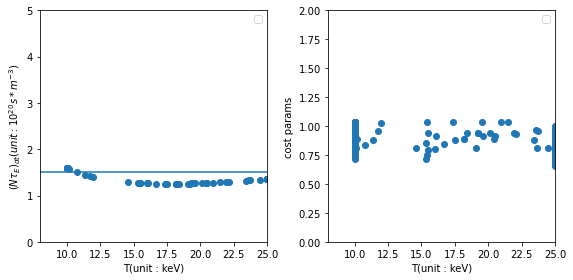

In [18]:
# n*tau*T graph
from src.lawson import Lawson
import matplotlib.pyplot as plt

lawson = Lawson()

# Lawson-criteria
T = np.array([result['control'][idx]['T_avg'] for idx in indices[0]])
n_tau = np.array([result['state'][idx]['n_tau'] for idx in indices[0]])
n_tau_T = T * n_tau

# Cost paramter
cost = np.array([result['state'][idx]['cost'] for idx in indices[0]])

fig, axes = plt.subplots(1,2,figsize = (8,4))
axes = axes.ravel()
ax = axes[0]
ax.scatter(T, n_tau)
ax.set_xlabel("T(unit : keV)")
ax.set_ylabel("$(N\\tau_E)_{dt}(unit:10^{20}s * m^{-3})$")
ax.axhline(1.5, 0, 1)
ax.set_xlim([8,25])
ax.set_ylim([0,5])
ax.legend()

ax = axes[1]
ax.scatter(T, cost)
ax.set_xlabel("T(unit : keV)")
ax.set_ylabel("cost params")
ax.set_xlim([8,25])
ax.set_ylim([0,2])
ax.legend()

fig.tight_layout()

In [27]:
arg_min = np.argmin(cost)
arg_min = indices[0][arg_min]

for key in result['state'][arg_min].keys():
    print("{} : {:.3f}".format(key, result['state'][arg_min][key]))
    
for key in result['control'][arg_min].keys():
    print("{} : {:.3f}".format(key, result['control'][arg_min][key]))
    

R : 4.663
a : 1.582
blanket_thickness : 1.233
coil_thickness : 0.527
n : 0.964
TBR : 0.718
beta : 6.463
tau : 1.411
Ip : 18.176
q : 6.418
f_BS : 0.686
Q_parallel : 728.296
n_g : 2.313
q_kink : 2.000
beta_troyon : 6.705
f_NC : 0.878
n_tau : 1.360
n_tau_lower : 1.705
cost : 0.651
betan : 3.500
k : 2.500
epsilon : 2.948
electric_power : 1409031250.000
T_avg : 25.000
B0 : 16.000
H : 1.500
armour_thickness : 0.150
RF_recirculating_rate : 0.050
